# Домашнее задание

Что в векторе твоем?

### Цель:
В этом ДЗ вы освоите работу с предобученными векторными представлениями.

### Описание/Пошаговая инструкция выполнения домашнего задания:

В качестве данных возьмите либо датасет, собранный в первом занятии (предпочтительно), либо скачайте данные с отзывами на фильмы с сайта IMDB (https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), в которых для каждого отзыва поставлена семантическая оценка — «позитивный» или «негативный».

1. Разбейте собранные данные на train/test, отложив 20–30% наблюдений для тестирования.
2. Примените tf-idf преобразование для текстового описания. Используйте как отдельные токены, так и биграммы, отсейте стоп-слова, а также слова, которые встречаются слишком редко или слишком часто (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена.
3. Обучите random forest или градиентный бустинг (LightGBM или catboost) на полученных векторах и подберите оптимальную комбинацию гиперпараметров с помощью GridSearch.
4. Теперь воспользуйтесь предобученными word2vec/fasttext эмбеддингами для векторизации текста. Векторизуйте тексты с помощью метода word2vec/fasttext с весами tf-idf.

> Совет: для текстов на русском языке можно взять предобученные эмбеддинги с сайта rusvectores https://rusvectores.org/ru/models/ (вам подходят эмбеддинги с параметром «тэгсет» НЕТ). Для английского языка можете воспользоваться word2vec, обученными на Google News.

5. Повторите эксперимент из пункта 3 с использованием полученных в пункте 4 векторов.



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import random

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
# from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from catboost import CatBoostClassifier

import gensim
from gensim.models import Word2Vec, KeyedVectors

In [4]:
df_imdb = pd.read_csv('data/IMDB_Dataset.csv')

In [5]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
df_imdb.shape

(50000, 2)

In [7]:
df_imdb.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [8]:
# df_imdb['sentiment'].value_counts()
df_imdb.groupby(['sentiment']).count()

,review
sentiment,
negative,25000
positive,25000


In [9]:
# Напишем функцию для отображения отзыва по id
def show_review(id):
    review = df_imdb.review[id]
    sentiment = df_imdb.sentiment[id]
    print(f'ID: {id} \n')
    print(f'Review: {review} \n')
    print(f'Sentiment: {sentiment}')

In [10]:
## посмотрим на случайно выбранный отзыв
num = random.randint(0, 49999)
show_review(num)

ID: 36289 

Review: Voor een verloren soldaat , for a lost soldier, is a sad example of how not to translate to film a touching, complex psychological study, of that most magical time in a man's life, when he is still a child, but starting to become a man. The novel records the real life experiences of Rudy van Dantzig, as told thru the boy Jeroen, during the waning days of WWII at age 11 as he deals with his incipient sexuality, and his deep fears of abandonment as he has been sent to the province of Friesland, north of Holland by his parents because of the lack of food in Amsterdam and has not heard from them in many months as the postal service has broken down.. The arrival of the liberating soldiers in the film, is presented in a painfully corny way, with the soldiers providing entertainment vaudeville style. Then one soldier, Walt, romances Jeroen and the pair is presented as two frolicking males.who consummate their love in a sexual experience. This taken in stride by the 11 yo J

Поскольку целевая переменная закодирована словами, необходимо привести ее к числовому виду

In [12]:
df_imdb['sentiment'] = df_imdb['sentiment'].map({'positive':1, 'negative':0})

In [13]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [14]:
show_review(num)

ID: 36289 

Review: Voor een verloren soldaat , for a lost soldier, is a sad example of how not to translate to film a touching, complex psychological study, of that most magical time in a man's life, when he is still a child, but starting to become a man. The novel records the real life experiences of Rudy van Dantzig, as told thru the boy Jeroen, during the waning days of WWII at age 11 as he deals with his incipient sexuality, and his deep fears of abandonment as he has been sent to the province of Friesland, north of Holland by his parents because of the lack of food in Amsterdam and has not heard from them in many months as the postal service has broken down.. The arrival of the liberating soldiers in the film, is presented in a painfully corny way, with the soldiers providing entertainment vaudeville style. Then one soldier, Walt, romances Jeroen and the pair is presented as two frolicking males.who consummate their love in a sexual experience. This taken in stride by the 11 yo J

## Предобработка текста

### Шаг 1. Токенизация

Инициализируем WordPunctTokenizer, с помощью которого затем разобьем текст на слова.

In [18]:
word_tokenizer = nltk.WordPunctTokenizer() # знаки препинания (группами) объединяются в один токен
tokens = word_tokenizer.tokenize('We will, we will rock you!!!!')
print(tokens)

['We', 'will', ',', 'we', 'will', 'rock', 'you', '!!!!']


Удалим специальные символы и переведем текст в нижний регистр 

In [20]:
def remove_special_characters(text, remove_digits=True):
    if remove_digits:
        pattern=r'[^a-zA-z\s]'
    else:
        pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text.lower()

In [21]:
df_imdb['review'] = df_imdb['review'].apply(remove_special_characters)

### Шаг 2. Удаление стоп-слов

In [23]:
# загружаем список стоп-слов пакета nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /home/vlad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/vlad/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [24]:
stopword_list = nltk.corpus.stopwords.words('english')

# примеры стоп-слов
print(len(stopword_list))
print(stopword_list[:10])

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [25]:
# создадим функцию удаления стоп-слов
def remove_stopwords(text):
    tokens = word_tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]

    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    

    return filtered_text

In [26]:
# применим созданную функцию к отзывам 
df_imdb['review']=df_imdb['review'].apply(remove_stopwords)

In [27]:
show_review(num)

ID: 36289 

Review: voor een verloren soldaat lost soldier sad example translate film touching complex psychological study magical time mans life still child starting become man novel records real life experiences rudy van dantzig told thru boy jeroen waning days wwii age deals incipient sexuality deep fears abandonment sent province friesland north holland parents lack food amsterdam heard many months postal service broken arrival liberating soldiers film presented painfully corny way soldiers providing entertainment vaudeville style one soldier walt romances jeroen pair presented two frolicking maleswho consummate love sexual experience taken stride yo jeroen reality somewhat different jeroen describes encounters walt detail oblique language misunderstanding nature walt aroused intense passion jeroen handles roughly final meeting jeroen bruised suffering painful wound shoulder walt bitten encounter walt rapes jeroen twice jeroen could easily avoided walt nd encounter walt first assau

### Шаг 3. Нормализация слов

Используем стемминг для нормализации

In [30]:
def simple_stemmer(text):
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    text= ' '.join([stemmer.stem(word) for word in text.split()])
    return text

In [31]:
df_imdb['review']=df_imdb['review'].apply(simple_stemmer)

Посмотрим, что у нас в итоге получилось

In [33]:
show_review(num)

ID: 36289 

Review: voor een verloren soldaat lost soldier sad exampl translat film touch complex psycholog studi magic time man life still child start becom man novel record real life experi rudi van dantzig told thru boy jeroen wane day wwii age deal incipi sexual deep fear abandon sent provinc friesland north holland parent lack food amsterdam heard mani month postal servic broken arriv liber soldier film present pain corni way soldier provid entertain vaudevill style one soldier walt romanc jeroen pair present two frolick maleswho consumm love sexual experi taken stride yo jeroen realiti somewhat differ jeroen describ encount walt detail obliqu languag misunderstand natur walt arous intens passion jeroen handl rough final meet jeroen bruis suffer pain wound shoulder walt bitten encount walt rape jeroen twice jeroen could easili avoid walt nd encount walt first assault walt clear anxious keep abus boy soldier jeroen keep seek walt mysteri human heart explain anyway film leav afterma

Видим, что специальные символы и стоп-слова удалены, текст нормализован и можем переходить к построению модели

## Разделим данные на train и test

In [36]:
data = df_imdb['review']
labels = df_imdb['sentiment']

In [37]:
data.shape, labels.shape

((50000,), (50000,))

In [38]:
train_texts, test_texts, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=13)

In [39]:
train_texts.shape, test_texts.shape, y_train.shape, y_test.shape

((40000,), (10000,), (40000,), (10000,))

In [40]:
train_texts[0]

'one review mention watch oz episod youll hook right exact happen mebr br first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use wordbr br call oz nicknam given oswald maximum secur state penitentari focus main emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awaybr br would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti surreal couldnt say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may bec

In [41]:
y_train[0]

1

## Построение модели

Применим tf-idf преобразование для создания векторного представления слов

In [44]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english", ngram_range=(1,3))
vectorizer

TfidfVectorizer(max_df=0.5, min_df=5, ngram_range=(1, 3), stop_words='english',
                sublinear_tf=True)

In [45]:
# Fit tf-idf on train texts
X_train = vectorizer.fit_transform(train_texts)
X_test  = vectorizer.transform(test_texts)

In [46]:
print('Tfidf_train:', X_train.shape)
print('Tfidf_test:', X_test.shape)

Tfidf_train: (40000, 145061)
Tfidf_test: (10000, 145061)


In [47]:
vectorizer.get_feature_names_out()

array(['_is_', '_the', 'aa', ..., 'zurer', 'zwart', 'zwick'], dtype=object)

In [48]:
vectorizer.idf_

array([9.80490026, 9.51721819, 9.19876446, ..., 9.80490026, 9.65074958,
       9.39943516])

In [49]:
tfidf_dict = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))

In [50]:
tfidf_dict['super'], tfidf_dict['trash']

(5.465433243300438, 5.0527478872187865)

In [51]:
max_idf = max(vectorizer.idf_)
max_idf

9.804900263555524

### Base line

Определим функцию для оценки качества модели

In [54]:
def quality(true_y, prediction_y):
    """
    Evaluates and returns the following metrics: Accuracy, Precision, Recall, F1-score, AUC
    """
    accuracy = round(accuracy_score(true_y, prediction_y), 3)
    precision = round(precision_score(true_y, prediction_y), 3)
    recall = round(recall_score(true_y, prediction_y), 3)
    f1 = round(f1_score(true_y, prediction_y), 3)
    auc = round(roc_auc_score(true_y, prediction_y), 3)
    print(f" Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"   Recall: {recall}")
    print(f" F1-score: {f1}")
    print(f"      AUC: {auc}")
    return [accuracy, precision, recall, f1, auc]

In [55]:
# словарь для сохранения значений метрик
results = {}

В качестве base line построим модель логистической регрессии пакета sklearn 

In [57]:
# инициализируем модель
logreg_model=LogisticRegression(penalty='l2', max_iter=500, C=1.0, random_state=13)

# обучим модель на tfidf векторах
logreg_model.fit(X_train,y_train)
print(logreg_model)

LogisticRegression(max_iter=500, random_state=13)


In [58]:
## Получаем результаты предсказаний 
y_pred=logreg_model.predict(X_test)
print(y_pred)

[0 0 1 ... 1 0 0]


In [59]:
# Classification report
logreg_tfidf_report=classification_report(y_test,y_pred,target_names=['Negative','Positive'])
print(logreg_tfidf_report)

              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      5058
    Positive       0.88      0.90      0.89      4942

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [60]:
results['LogReg'] = quality(y_test, y_pred)

 Accuracy: 0.892
Precision: 0.879
   Recall: 0.905
 F1-score: 0.892
      AUC: 0.892


In [61]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
LogReg,0.892,0.879,0.905,0.892,0.892


## Catboost

Построим валидационную кривую для количества деревьев

### Catboost number of trees validation curve

n_trees: 1 | AUC Train 0.701846965032976 | AUC Test 0.7082515423275356
n_trees: 5 | AUC Train 0.7836076626404428 | AUC Test 0.7873337436285428
n_trees: 10 | AUC Train 0.8122021281198976 | AUC Test 0.8140180942747657
n_trees: 50 | AUC Train 0.8730396272632653 | AUC Test 0.8512305415816751
n_trees: 100 | AUC Train 0.8975298407259605 | AUC Test 0.8568976641496879
n_trees: 200 | AUC Train 0.9060488948712059 | AUC Test 0.8666070906501179
n_trees: 300 | AUC Train 0.9083308015620409 | AUC Test 0.8676643129099452
n_trees: 400 | AUC Train 0.9099298000096182 | AUC Test 0.8669082911796611
n_trees: 500 | AUC Train 0.9114276376064322 | AUC Test 0.8669839413591492




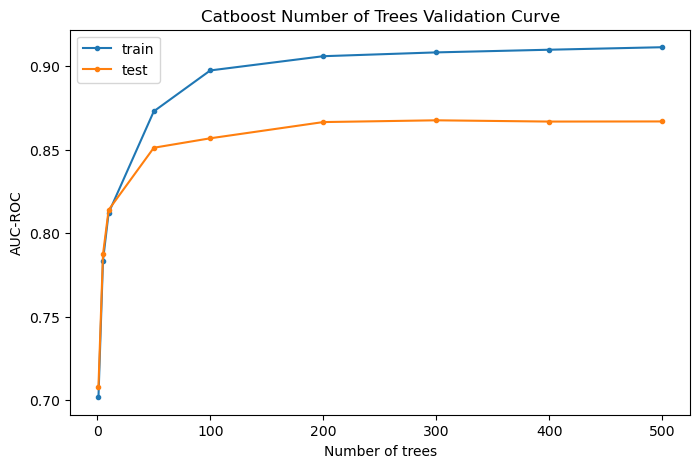

In [65]:
n_trees = [1, 5, 10, 50, 100, 200, 300, 400, 500]
quals_train = []
quals_test = []
for n in n_trees:
    #clf = CatBoostClassifier(iterations=n, task_type="GPU", devices='0', logging_level='Silent', random_state=13)
    clf = CatBoostClassifier(iterations=n, logging_level='Silent', random_state=13)
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict(X_train))
    q_test = roc_auc_score(y_test, clf.predict(X_test))

    quals_train.append(q_train)
    quals_test.append(q_test)
    print(f"n_trees: {n} | AUC Train {q_train} | AUC Test {q_test}")

print('\n')
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.title('Catboost Number of Trees Validation Curve')
plt.legend()

plt.show()

In [66]:
sorted(list(zip(quals_test, n_trees)), reverse=True)

[(0.8676643129099452, 300),
 (0.8669839413591492, 500),
 (0.8669082911796611, 400),
 (0.8666070906501179, 200),
 (0.8568976641496879, 100),
 (0.8512305415816751, 50),
 (0.8140180942747657, 10),
 (0.7873337436285428, 5),
 (0.7082515423275356, 1)]

Видим, что лучшее значение метрики AUC достигается при 300 деревьях

### CatBoost Learning Rate Validation Curve

Построим валидационные кривые для параметра learning rate

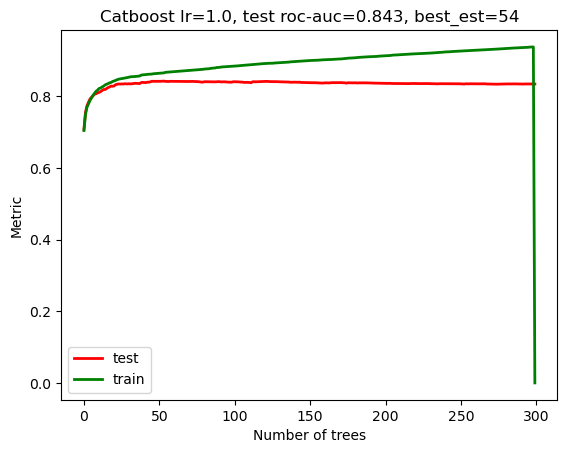

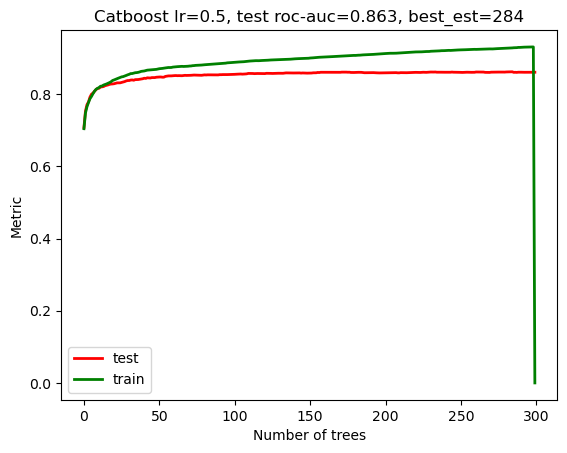

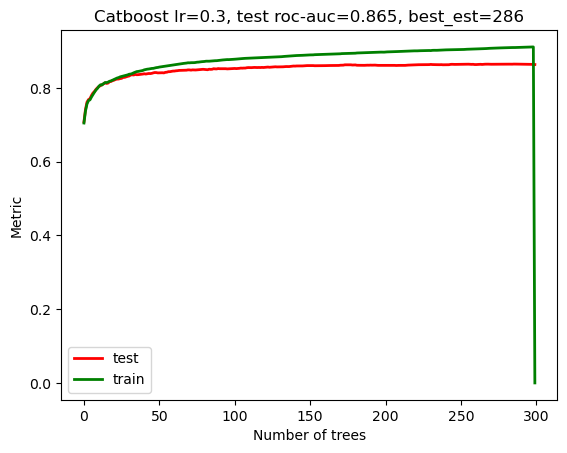

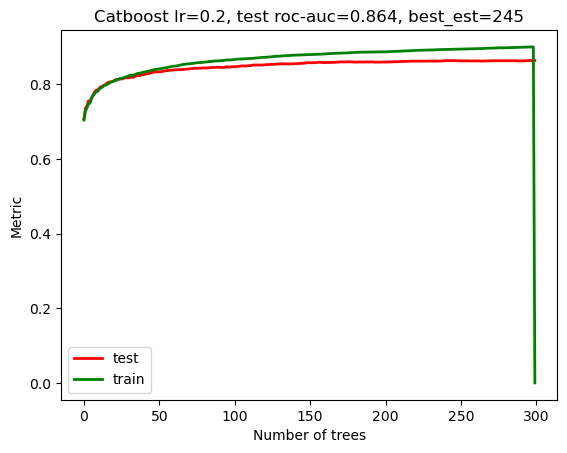

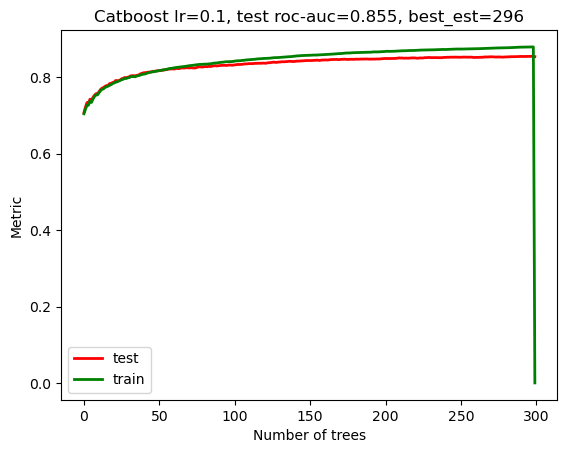

In [70]:
n_iterations = 300
for learning_rate in [1, 0.5, 0.3, 0.2, 0.1]:

    cbt = CatBoostClassifier(iterations=n_iterations, learning_rate=learning_rate, task_type="GPU", devices='0', logging_level='Silent', random_state=13).fit(X_train, y_train)
    
    test_deviance = np.zeros((n_iterations,), dtype=np.float64)
    for i, y_pred in enumerate(cbt.staged_predict(X_test, prediction_type='Class')):
        test_deviance[i] = roc_auc_score(y_test, y_pred)
    
    train_deviance = np.zeros((n_iterations,), dtype=np.float64)
    for i, y_pred in enumerate(cbt.staged_predict(X_train, prediction_type='Class', ntree_start=0, ntree_end=i)):
        train_deviance[i] = roc_auc_score(y_train, y_pred)

    plt.figure()
    plt.plot(test_deviance, 'r', linewidth=2)
    plt.plot(train_deviance, 'g', linewidth=2)
    plt.legend(['test', 'train'])
    
    plt.title('Catboost lr=%.1f, test roc-auc=%.3f, best_est=%d' % (learning_rate, test_deviance.max(), test_deviance.argmax()+1))
    plt.xlabel('Number of trees')
    plt.ylabel('Metric')

Запустим модель с лучшим набором параметров lr=0.3, n_estimators=286

In [72]:
catboost = CatBoostClassifier(iterations=286, learning_rate=0.3, logging_level='Silent', random_state=13)
catboost.fit(X_train, y_train)
pred = catboost.predict(X_test)

In [73]:
results['CatBoost-VC'] = quality(y_test, pred)

 Accuracy: 0.869
Precision: 0.859
   Recall: 0.878
 F1-score: 0.868
      AUC: 0.869


In [74]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
LogReg,0.892,0.879,0.905,0.892,0.892
CatBoost-VC,0.869,0.859,0.878,0.868,0.869


### CatBoost on GridSearch

In [76]:
%%time
# Define Gradient Boosting classifier with default parameters
clf = CatBoostClassifier(task_type="GPU", devices='0', logging_level='Silent', random_state=13)

# Define GridSearch parameters
parameters = {'n_estimators':[200, 300],
              'max_depth':[1,3,5],
              'learning_rate':[0.5,0.3,0.2,0.1]
             }

# Estimate grid of the classifier hyperparameters
gs = GridSearchCV(clf,                 # Classifier object to optimize
                  parameters,          # Grid of the hyperparameters
                  scoring='roc_auc',   # Classification quality metric to optimize
                  cv=3                 # Number of folds in KFolds cross-validation (CV)
                 )

# Run Grid Search optimization
gs.fit(X_train, y_train)
gs.best_params_

CPU times: user 14h 26min, sys: 31min 6s, total: 14h 57min 6s
Wall time: 40min 2s


{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}

In [77]:
pred_gs = gs.predict(X_test)

In [78]:
results['CatBoost-GS'] = quality(y_test, pred_gs)

 Accuracy: 0.861
Precision: 0.844
   Recall: 0.883
 F1-score: 0.863
      AUC: 0.862


In [79]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
LogReg,0.892,0.879,0.905,0.892,0.892
CatBoost-VC,0.869,0.859,0.878,0.868,0.869
CatBoost-GS,0.861,0.844,0.883,0.863,0.862


## Word2Vec

In [81]:
# Load Google's pre-trained Word2Vec model.
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin', binary=True)

In [82]:
w2v_model.vector_size

300

In [83]:
w2v_model.most_similar('ubiquitous')

[('omnipresent', 0.7231091856956482),
 ('ubiquity', 0.6775019764900208),
 ('ubiquitious', 0.608471691608429),
 ('omnipresence', 0.5932484865188599),
 ('commonplace', 0.5638182163238525),
 ('de_rigueur', 0.5580129623413086),
 ('pervasive', 0.5519276261329651),
 ('passé', 0.5518507361412048),
 ('ubiquitously', 0.5300421118736267),
 ('ubiquitousness', 0.5208093523979187)]

In [84]:
#Inspect the model
print('Shape :',w2v_model.vectors.shape)
word2vec_vocab = w2v_model.index_to_key 
word2vec_vocab_lower = [item.lower() for item in word2vec_vocab]
print('Total vocabulary counts :',len(word2vec_vocab))

Shape : (3000000, 300)
Total vocabulary counts : 3000000


In [85]:
type(word2vec_vocab)

list

In [86]:
# our original data structures: data = review texts; labels = sentiments
data[0], labels[0]

('one review mention watch oz episod youll hook right exact happen mebr br first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use wordbr br call oz nicknam given oswald maximum secur state penitentari focus main emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awaybr br would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti surreal couldnt say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may be

In [87]:
data.shape, labels.shape

((50000,), (50000,))

### Text Preprocessing

Word2Vec строит эмбеддинги для отдельных слов (не предложений), соответственно, поскольку основная предбработка текстов у нас уже была выполнена, нам остается разделить обзоры на отдельные слова 

In [90]:
#preprocess the text
def preprocess_corpus(texts):
    
    tokenized = []
    for text in texts:
        tokens = word_tokenize(text)

        # Remove punctuation and digit and make word in lowercase
        # lower = [token.lower() for token in tokens if token not in punctuation and not token.isdigit()]

        # Remove stopwords
        # Stopwords = set(stopwords.words("english"))
        # words = [token for token in lower if token not in Stopwords]
        tokenized.append(tokens)
    
    return tokenized

In [91]:
texts_processed = preprocess_corpus(data)

In [92]:
print('Original Texts :',data[0], '\n')
print('Processed Texts :',texts_processed[0], '\n')
print('Sentiment :',labels[0])

Original Texts : one review mention watch oz episod youll hook right exact happen mebr br first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use wordbr br call oz nicknam given oswald maximum secur state penitentari focus main emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awaybr br would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti surreal couldnt say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi 

### Embeddings and Feature vector

In [94]:
w2v_model.key_to_index
for word in texts_processed[0][:10]:
    try:
        # word = word.lower()
        embeddings = w2v_model.key_to_index[word]
        print(word,'-->',embeddings)
    except:
        print(word)

one --> 45
review --> 1081
mention --> 3420
watch --> 1228
oz --> 18243
episod
youll --> 180624
hook --> 7390
right --> 168
exact --> 5221


In [95]:
for word in texts_processed[0][:20]:
    try:
        # word = word.lower()
        tfidf_weight = tfidf_dict[word]
        print(word,'-->',tfidf_weight)
    except:
        print(word)

one
review --> 3.695282378990963
mention --> 3.9474434129629454
watch --> 2.0206351227110764
oz --> 6.633815102523672
episod --> 3.945064158925978
youll --> 4.069403813409794
hook --> 5.525922004781089
right --> 3.1632830274604515
exact --> 4.166545594221778
happen --> 3.182163939605684
mebr --> 5.7133373442953
br
first
thing --> 2.4385604726530863
struck --> 6.21216466999449
oz --> 6.633815102523672
brutal --> 5.122769036431304
unflinch --> 8.100152171317099
scene --> 2.360651614058818


In [96]:
token = 'review'
w2v_model[token].shape

(300,)

In [97]:
# Creating a feature vector by averaging all embeddings for all sentences
def features_embeddings(list_of_lists):
    
    # feature vector column length 
    DIMENSION = w2v_model.vector_size
    
    # Zero vector if words not in our w2v_model vocubulary
    zero_vector = np.zeros(DIMENSION)
    
    features = []
    
    # feature vector for each sentence in list_of_lists one by one
    for tokens in list_of_lists:
        
        # feature vector for a single sentence
        feature =  np.zeros(DIMENSION) # shape = 1X DIMENSION
        
        # count for each token/word in a tokens or sentence
        feature_counts = 0 + 1e-5   # to avoid divide-by-zero 
        for token in tokens:
            if token in w2v_model:
                # Getting TF-IDF weights from dictionary
                # if a word was never seen - it must be at least as infrequent as any of the known words 
                # so the default idf is the max of known idf's
                try:
                    tfidf_weight = tfidf_dict[token]
                except:
                    tfidf_weight = max_idf
                 # Here both feature and w2v_model[token] are of same shape : 1X DIMENSION
                feature += w2v_model[token] * tfidf_weight
                feature_counts +=1    # Count increases for each token in a tokens
         
        # Average the feature values for each tokens
        if(feature_counts !=0 ):        # for non empty tokens
            features.append(feature/feature_counts) 
        else:                           # for empty tokens
            features.append(zero_vector)
            
    return features

In [98]:
train_vectors = features_embeddings(texts_processed)
print(len(train_vectors))
train_vectors[2999].shape

50000


(300,)

## Build Classification Model

In [100]:
# Split train and test data
X_train2, X_test2, y_train2, y_test2 = train_test_split(train_vectors, labels, test_size = 0.2,  random_state=13)
len(X_train2), len(X_test2), len(y_train2), len(y_test2)

(40000, 10000, 40000, 10000)

### Logistic Regression

In [102]:
# logreg_model = LogisticRegression(penalty='l2', max_iter=500, C=1.0, random_state=13)
LogReg_model_w2v = LogisticRegression(random_state=13) 
LogReg_model_w2v.fit(X_train2, y_train2) # train the model(timing it with an IPython "magic command")

y_pred2 = LogReg_model_w2v.predict(X_test2) 
print(classification_report(y_pred2, y_test2, target_names = ['Positive','Negative']))

              precision    recall  f1-score   support

    Positive       0.80      0.80      0.80      5048
    Negative       0.80      0.80      0.80      4952

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



In [103]:
results['LogReg-W2V'] = quality(y_test2, y_pred2)

 Accuracy: 0.798
Precision: 0.795
   Recall: 0.797
 F1-score: 0.796
      AUC: 0.798


In [104]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
LogReg,0.892,0.879,0.905,0.892,0.892
CatBoost-VC,0.869,0.859,0.878,0.868,0.869
CatBoost-GS,0.861,0.844,0.883,0.863,0.862
LogReg-W2V,0.798,0.795,0.797,0.796,0.798


### Catboost Number of Trees Validation Curve

n_trees: 1 | AUC Train 0.6612066582479958 | AUC Test 0.657027129570555
n_trees: 5 | AUC Train 0.7239997088375513 | AUC Test 0.7175666357665088
n_trees: 10 | AUC Train 0.7487032515943459 | AUC Test 0.7372982908580179
n_trees: 50 | AUC Train 0.816275702378657 | AUC Test 0.7615632759544125
n_trees: 100 | AUC Train 0.858668518902244 | AUC Test 0.7695898760137164
n_trees: 200 | AUC Train 0.8731209604472774 | AUC Test 0.7791062365351882
n_trees: 300 | AUC Train 0.8814494379897736 | AUC Test 0.779968072503836
n_trees: 400 | AUC Train 0.8839981544244787 | AUC Test 0.7849186186493254
n_trees: 500 | AUC Train 0.8870484700776333 | AUC Test 0.7839662905040504
n_trees: 600 | AUC Train 0.88989979905731 | AUC Test 0.7859233938518766
n_trees: 700 | AUC Train 0.8915235802133096 | AUC Test 0.7870154207950222
n_trees: 800 | AUC Train 0.8933950434523155 | AUC Test 0.7851826941833293
n_trees: 900 | AUC Train 0.893174754099682 | AUC Test 0.7880726430548494
n_trees: 1000 | AUC Train 0.895374917603057 | AUC T

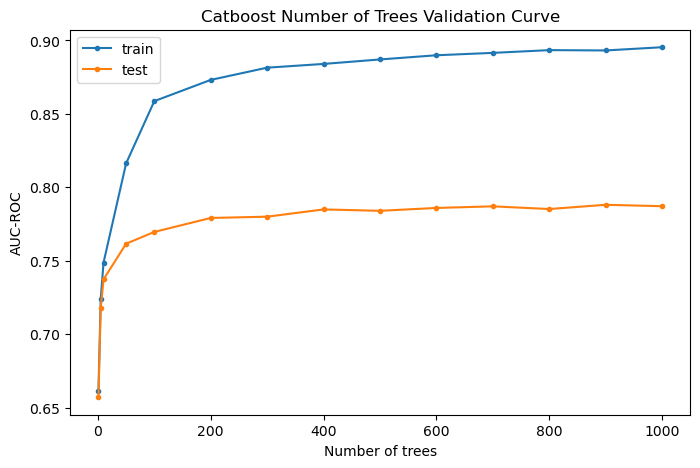

In [106]:
n_trees = [1, 5, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
quals_train = []
quals_test = []
for n in n_trees:
    # clf = CatBoostClassifier(iterations=n, task_type="GPU", devices='0', logging_level='Silent', random_state=13)
    clf = CatBoostClassifier(iterations=n, logging_level='Silent', random_state=13)
    clf.fit(X_train2, y_train2)
    q_train = roc_auc_score(y_train2, clf.predict(X_train2))
    q_test = roc_auc_score(y_test2, clf.predict(X_test2))

    quals_train.append(q_train)
    quals_test.append(q_test)
    print(f"n_trees: {n} | AUC Train {q_train} | AUC Test {q_test}")

print('\n')
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.title('Catboost Number of Trees Validation Curve')
plt.legend()

plt.show()

In [107]:
sorted(list(zip(quals_test, n_trees)), reverse=True)

[(0.7880726430548494, 900),
 (0.7871073131600589, 1000),
 (0.7870154207950222, 700),
 (0.7859233938518766, 600),
 (0.7851826941833293, 800),
 (0.7849186186493254, 400),
 (0.7839662905040504, 500),
 (0.779968072503836, 300),
 (0.7791062365351882, 200),
 (0.7695898760137164, 100),
 (0.7615632759544125, 50),
 (0.7372982908580179, 10),
 (0.7175666357665088, 5),
 (0.657027129570555, 1)]

### Catboost Learning Rate Validation Curve

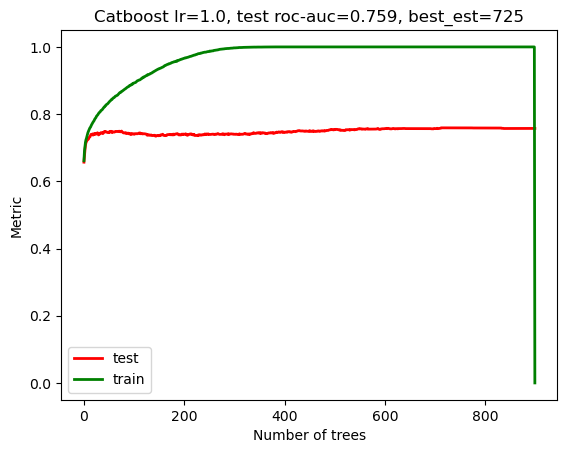

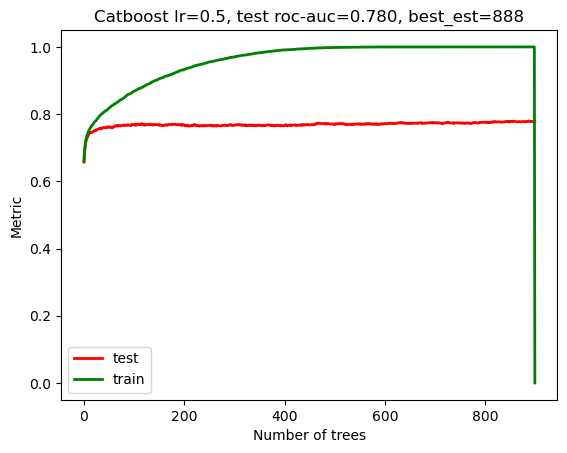

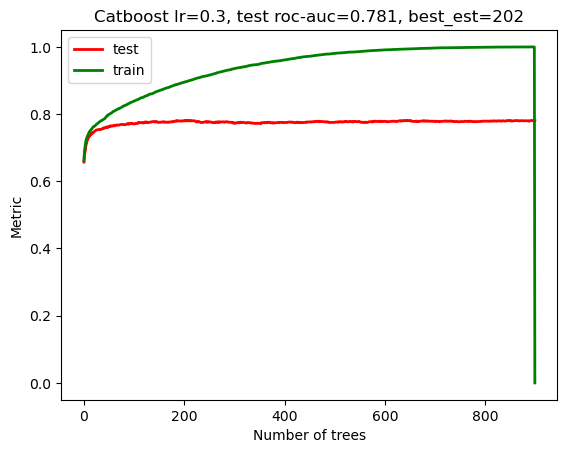

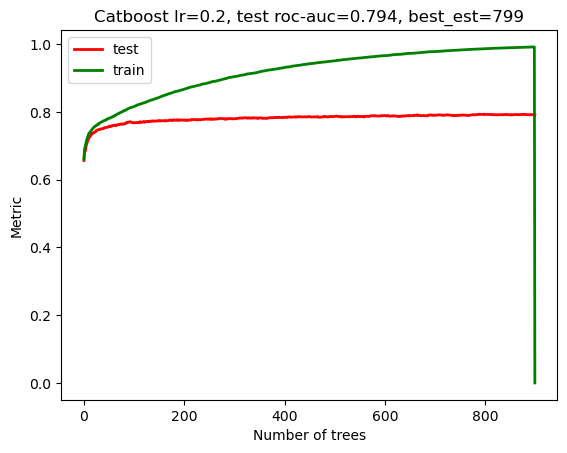

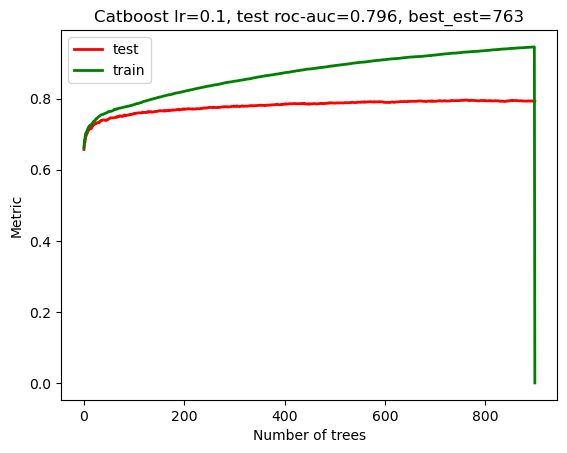

In [109]:
n_iterations = 900
for learning_rate in [1, 0.5, 0.3, 0.2, 0.1]:

    # cbt = CatBoostClassifier(iterations=n_iterations, learning_rate=learning_rate, task_type="GPU", devices='0', logging_level='Silent', random_state=13).fit(X_train, y_train)
    cbt = CatBoostClassifier(iterations=n_iterations, learning_rate=learning_rate, logging_level='Silent', random_state=13)
    cbt.fit(X_train2, y_train2)
    
    test_deviance = np.zeros((n_iterations,), dtype=np.float64)
    for i, y_pred in enumerate(cbt.staged_predict(X_test2, prediction_type='Class', ntree_start=0)):
        test_deviance[i] = roc_auc_score(y_test2, y_pred)
    
    train_deviance = np.zeros((n_iterations,), dtype=np.float64)
    for i, y_pred in enumerate(cbt.staged_predict(X_train2, prediction_type='Class', ntree_start=0, ntree_end=i)):
        train_deviance[i] = roc_auc_score(y_train2, y_pred)

    plt.figure()
    plt.plot(test_deviance, 'r', linewidth=2)
    plt.plot(train_deviance, 'g', linewidth=2)
    plt.legend(['test', 'train'])
    
    plt.title('Catboost lr=%.1f, test roc-auc=%.3f, best_est=%d' % (learning_rate, test_deviance.max(), test_deviance.argmax()+1))
    plt.xlabel('Number of trees')
    plt.ylabel('Metric')

Запустим модель с лучшим набором параметров lr = 0.1, n_estimator = 763

In [193]:
catboost = CatBoostClassifier(iterations=763, learning_rate=0.1, logging_level='Silent', random_state=13)
catboost.fit(X_train2, y_train2)
pred2 = catboost.predict(X_test2)

In [194]:
results['CatBoost-W2V'] = quality(y_test2, pred2)

 Accuracy: 0.796
Precision: 0.794
   Recall: 0.793
 F1-score: 0.794
      AUC: 0.796


In [195]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
LogReg,0.892,0.879,0.905,0.892,0.892
CatBoost-VC,0.869,0.859,0.878,0.868,0.869
CatBoost-GS,0.861,0.844,0.883,0.863,0.862
LogReg-W2V,0.798,0.795,0.797,0.796,0.798
CatBoost-W2V,0.796,0.794,0.793,0.794,0.796


## Итотоговые результаты

### Таблица лидеров

In [199]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T.sort_values(by=['AUC'], ascending=False)

,Accuracy,Precision,Recall,F1-score,AUC
LogReg,0.892,0.879,0.905,0.892,0.892
CatBoost-VC,0.869,0.859,0.878,0.868,0.869
CatBoost-GS,0.861,0.844,0.883,0.863,0.862
LogReg-W2V,0.798,0.795,0.797,0.796,0.798
CatBoost-W2V,0.796,0.794,0.793,0.794,0.796


### Выводы

- Как мы видим, лучшие результаты (f1-score 0.89) показывает базовая модель логистической регрессии. Использование более сложных алгоритмов, таких как бустинг, а также предобученных эмбеддингов word2vec усложняет модель, увеличивает время расчетов и при этом, демонстрирует худшие результаты.

- Для такой относительно несложной задачи, как анализ тональности, сначала имеет смысл попробовать самые простые методы и вполне возможно, они будут лучшим выбором.